# Spatial communications

SOAPy develops a new method that simultaneously utilizes spatial location and gene expression to calculate interaction scores (affinity and strength) and then outputs significant Ligand-Receptor(LR) interactions. It can not only infers short-range cell communication that relies on contact LRs to directly deliver signaling between adjacent cells; but also infer long-range cell communication that does not require cell–cell contact, rather depending on the diffusion of signaling molecules from one cell to another after secretion
Here we will use the human ovarian cancer MERSCOPE sample as a demonstration

Source data download from https://info.vizgen.com/ffpe-showcase (Ovarian cancer 3)

Our annotation of cells can be download from https://zenodo.org/records/14588408.

Ligand-receptor database download from https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs.

## Read and preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import numba as nb
import SOAPy_st as sp

In [2]:
data = pd.read_csv('/csb2/project/SpatialPackage_whq/Tutorial/data/MERSCOPE/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv', index_col=0)
metadata = pd.read_csv('/csb2/project/SpatialPackage_whq/Tutorial/data/MERSCOPE/HumanOvarianCancerPatient2Slice2_cell_metadata.csv', index_col=0)
metadata = metadata.loc[list(data.index), :]
celltype = pd.read_csv('/csb2/project/SpatialPackage_whq/Tutorial/data/MERSCOPE/OV_MERSCOPE_cluster.csv', index_col=0)

In [3]:
adata = sp.pp.read_csv2adata(
    express = data,
    meta = metadata,
    spatial = ['center_x', 'center_y']
)

In [4]:
adata = adata[celltype.index, :].copy()
adata.obs['cluster'] = celltype['cluster'].tolist()

In [5]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=10000)
sc.pp.log1p(adata)

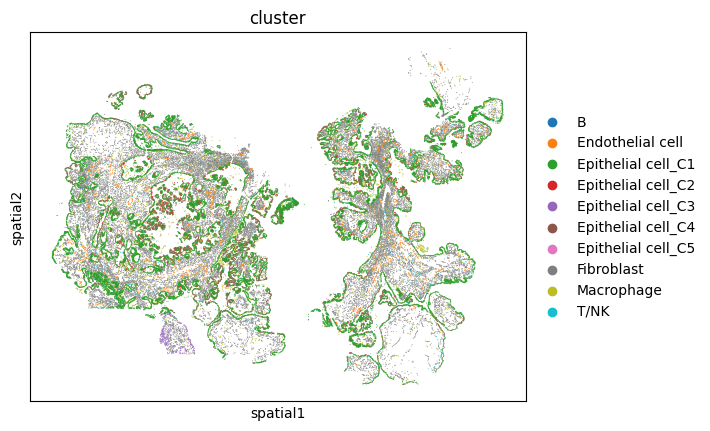

In [6]:
sc.pl.embedding(adata, basis="spatial", color='cluster')

Reading ovarian cancer data and ligand-receptor data (using the dataset provided in cellchat)

In [7]:
lr_pairs = sp.tl.lr_pairs(
    'human',
    Annotation_key='annotation',
    ligand_key='ligand_symbol',
    receptor_key='receptor_symbol'
)
lr_pairs.get_complexes()

## Run

In [8]:
from scipy import sparse
adata = sp.tl.cell_type_level_communication(
    adata=adata,
    lr_pairs=lr_pairs,
    cluster_key='cluster',
    n_iters=100, 
    m=0.5,
    contact_key='Cell-Cell Contact',
    secretory_key='Secreted Signaling',
    secretory_radius=150
)

In contact mode, The average number of neighbors is 5.699148588756707
In contact mode, total of 0 spots have no neighbors


37 contact ligand-receptor pairs.: 100%|████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In secretory mode, The average number of neighbors is 376.62670573827853
In secretory mode, total of 0 spots have no neighbors


86 secretory ligand-receptor pairs.: 100%|██████████████████████████████████████████████████████████████ [ time left: 00:00 ]


## Visualization

In the following, network and chord diagrams are used to show the communication strength between each cell type, respectively.

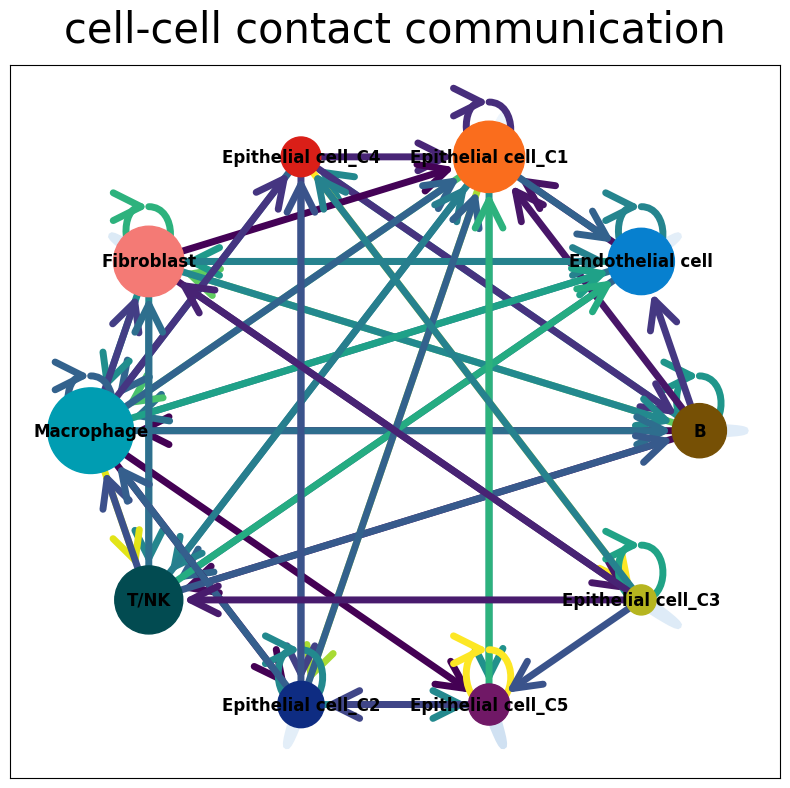

In [9]:
sp.pl.show_ccc_netplot(adata, lr_type='contact')

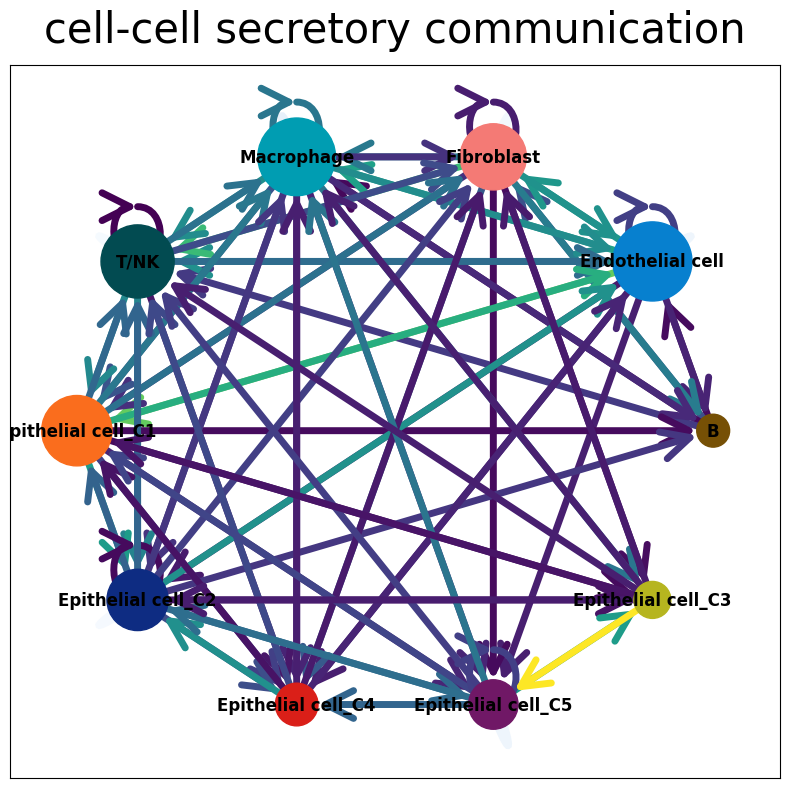

In [10]:
sp.pl.show_ccc_netplot(adata, lr_type='secretory')

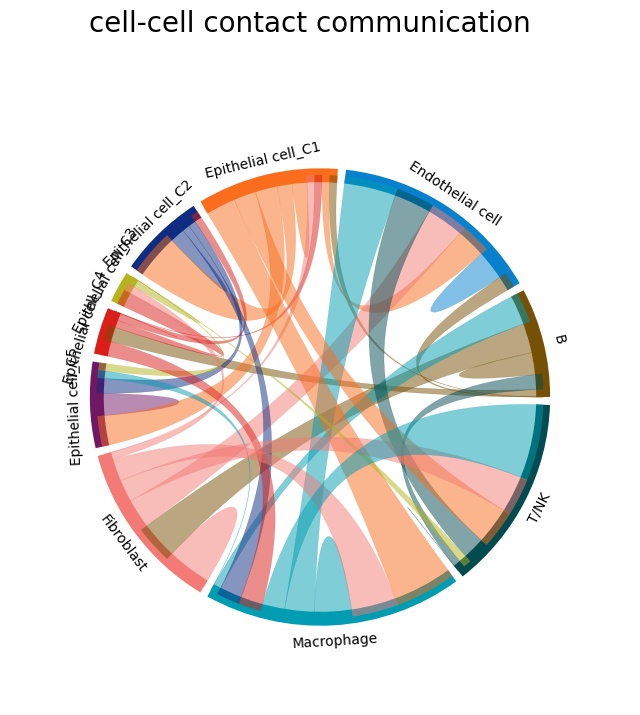

In [11]:
sp.pl.show_ccc_chordplot(adata, lr_type='contact')

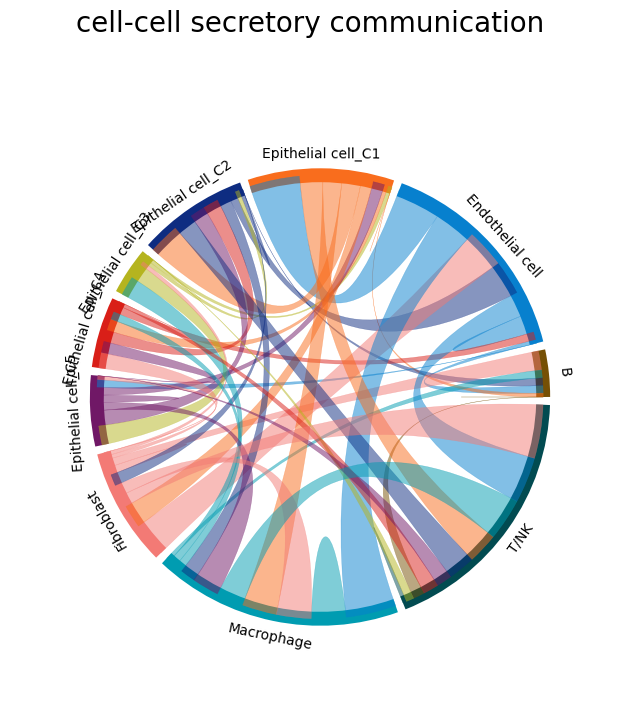

In [12]:
sp.pl.show_ccc_chordplot(adata, lr_type='secretory')

Significant ligand-receptor pairs between each cell type are shown by dotplot.

<Axes: title={'center': 'contact lr pairs'}, xlabel='cell type', ylabel='LR-pair'>

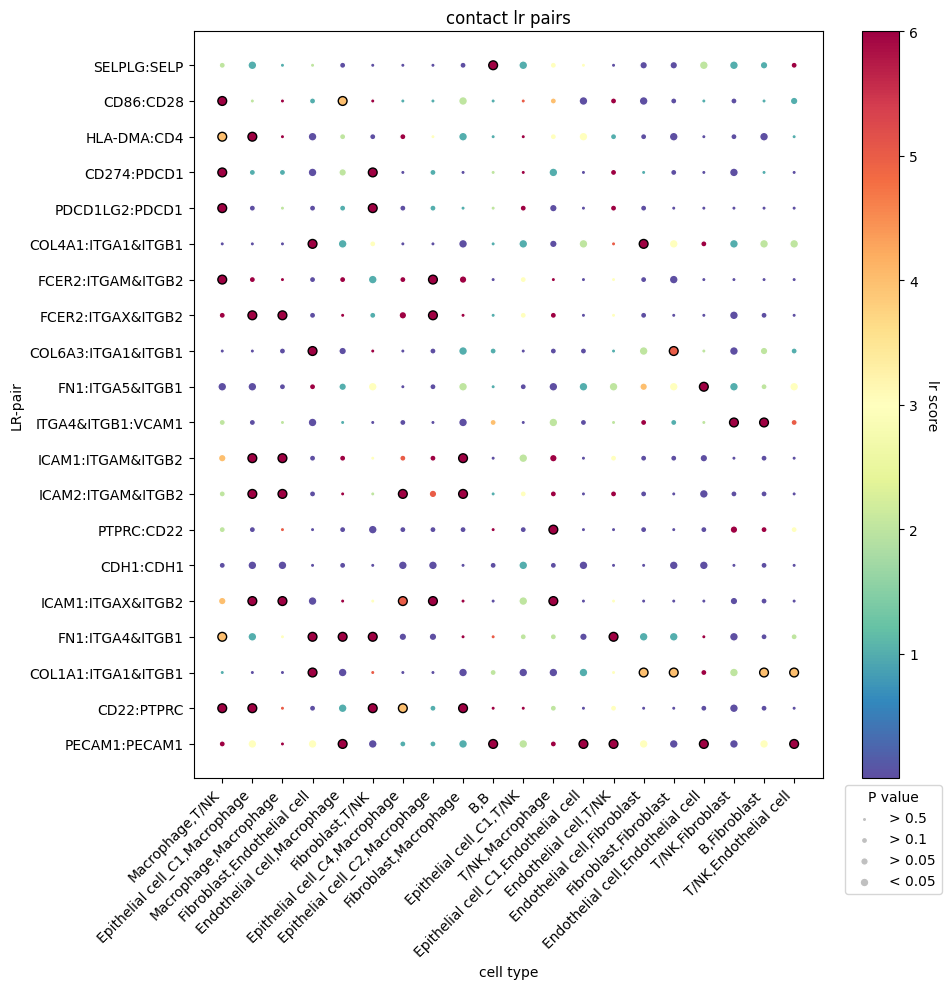

In [13]:
sp.pl.show_ccc_dotplot(
    adata, 
    lr_type='contact', 
    strength_cutoff=4.0, 
    strength_max=6.0,
    n_top_cts=20,
    n_top_lrs=20,
    figsize=(10, 10)
)

<Axes: title={'center': 'secretory lr pairs'}, xlabel='cell type', ylabel='LR-pair'>

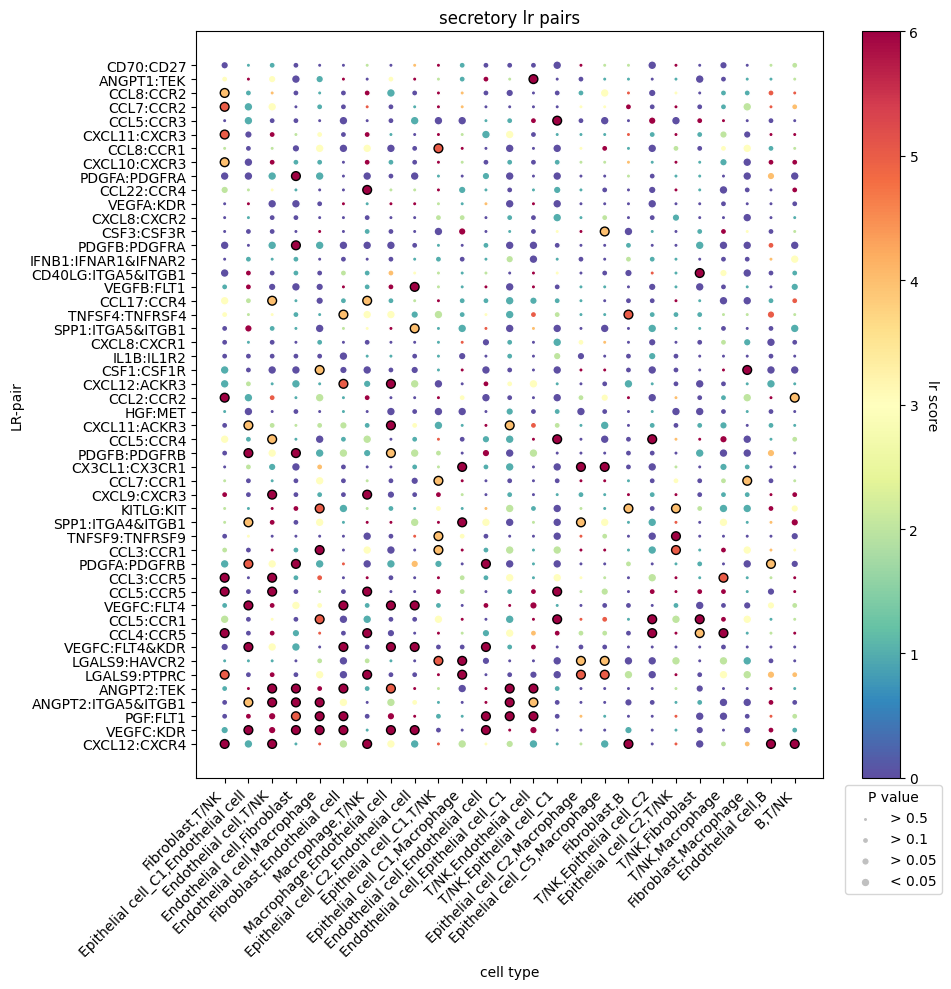

In [14]:
sp.pl.show_ccc_dotplot(
    adata, 
    lr_type='secretory', 
    strength_cutoff=4.0, 
    strength_max=6.0,
    n_top_cts=25,
    n_top_lrs=50,
    figsize=(10, 10)
)

Examples are seleced to show the real distribution of ligands and receptors in each cell in the space.

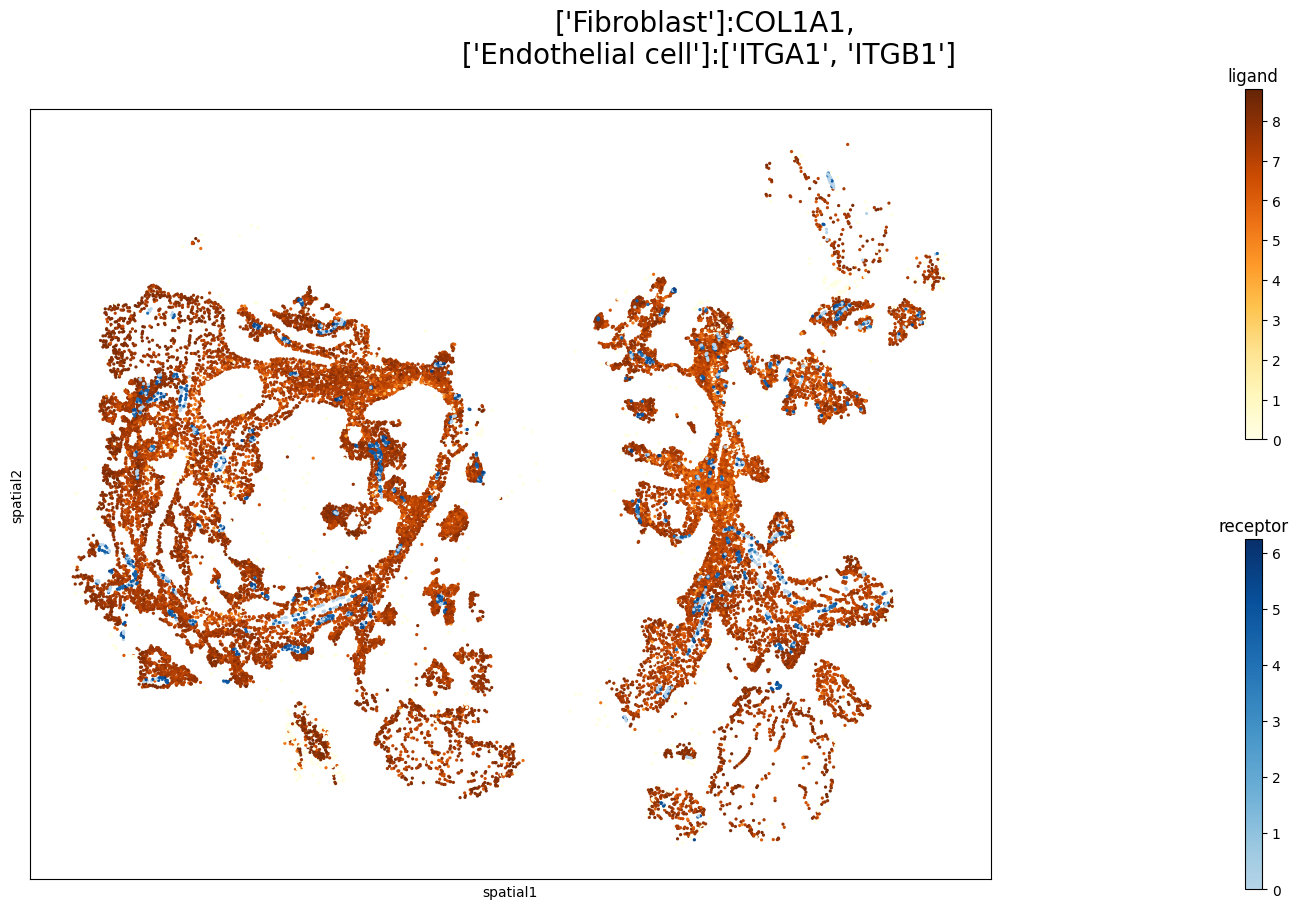

In [15]:
sp.pl.show_ccc_embedding(
    adata,
    cluster_key='cluster',
    ligand='COL1A1',
    receptor=['ITGA1', 'ITGB1'],
    ligand_clusters='Fibroblast',
    receptor_clusters='Endothelial cell',
    figsize=(18, 10),
    title='Short range communications'
)

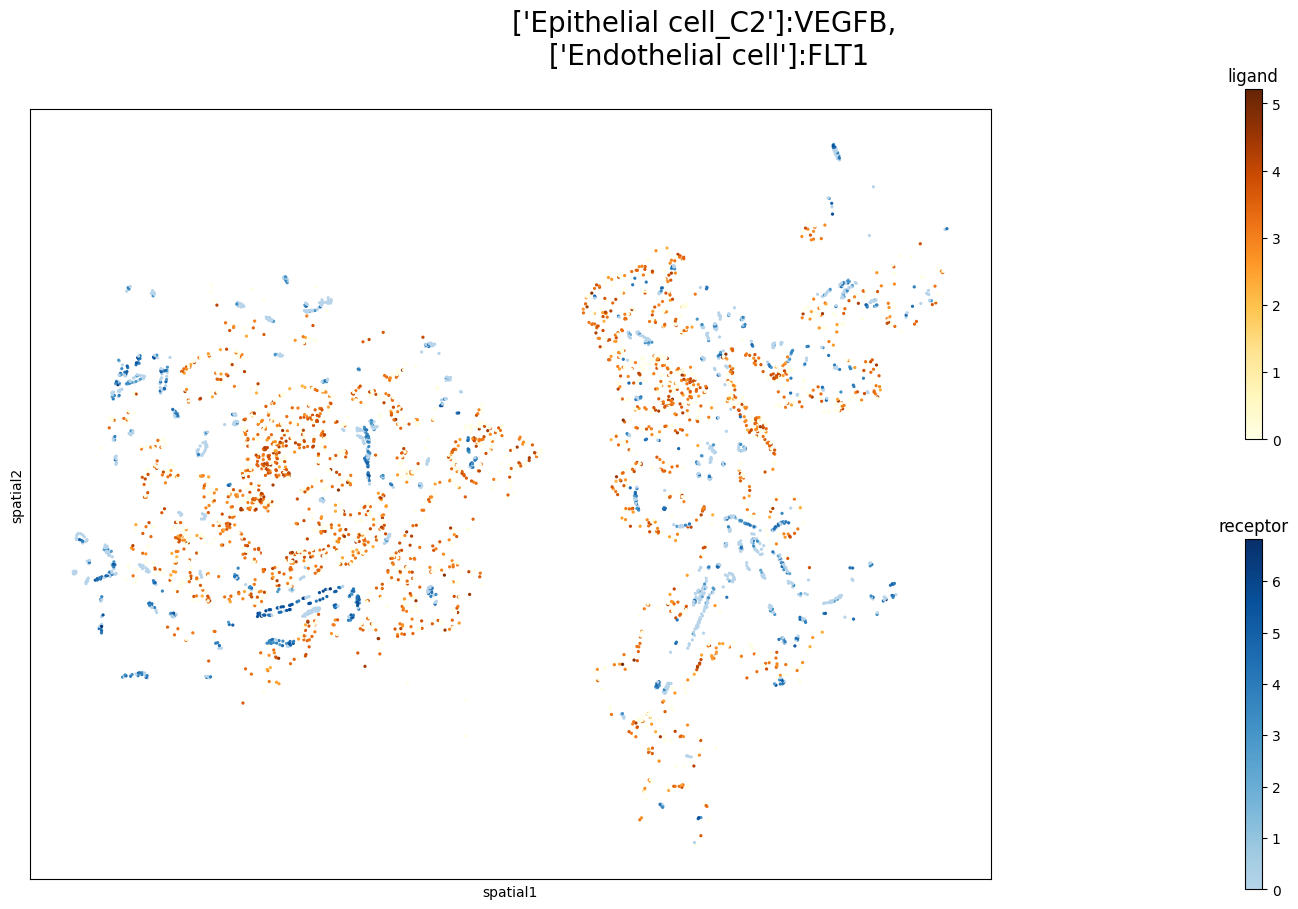

In [16]:
sp.pl.show_ccc_embedding(
    adata,
    cluster_key = 'cluster',
    ligand='VEGFB',
    receptor='FLT1',
    ligand_clusters='Epithelial cell_C2',
    receptor_clusters='Endothelial cell',
    figsize=(18, 10),
    title='Long range communications'
)